In [1]:
import time
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv

In [2]:
# Training NN on CPU is preferred.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Reset RNG seed
random_state = 12345

random_state = int(random_state)
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True

In [4]:
# Hyperparameters for NN
batch_size = 256
lr = 0.001
epochs = 50

In [5]:
path_data = 'data'

# Download the MNIST dataset
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
])
train_dataset = tv.datasets.MNIST(
    path_data,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    path_data,
    train=False, 
    download=True,
    transform=transform)

# Wrap the data with PyTorch DataLoader class for mini-batch support
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # We don't need to shuffle test set
)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # MaxPool is more computational efficient;
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        # print(x.size())  # If you don't the size of a hidden layer, you can just print it;
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No need to call Softmax function;
        return x
# CrossEntropyLoss combines LogSoftmax and NLLLoss

In [7]:
# Test model
cnn = Net()

x, _ = next(iter(test_loader))
print(x.size())

out = cnn(x)
print(out.size())

torch.Size([256, 1, 28, 28])
torch.Size([256, 10])


In [8]:
def train(model, loader, optimizer, loss):
    model.train()  # Calling train() ensures PyTorch computes gradient, applies Dropout layer, and more.
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        output = model(x)
        los = loss(output, y)
        los.backward()
        optimizer.step()

        # for display
        total_loss += los.item() * batch_size
        preds = output.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [9]:
def validate(model, loader, loss):
    model.eval()  # Disable gradient computation and more
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            los = loss(output, y)
            total_loss += los.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [10]:
cnn = Net()

# Move model to GPU
cnn.to(device)

# Define loss function and optimization method
optimizer = torch.optim.SGD(cnn.parameters(), lr=lr, momentum=0.9)
loss = nn.CrossEntropyLoss()

In [11]:
train_losses = np.zeros(epochs, dtype=float)
test_losses = np.zeros(epochs, dtype=float)
train_accs = np.zeros(epochs, dtype=float)
test_accs = np.zeros(epochs, dtype=float)

since = time.time()
for i, epoch in enumerate(range(epochs)):
    start = time.time()
    train_losses[i], train_accs[i] = train(cnn, train_loader, optimizer, loss)
    test_losses[i], test_accs[i] = validate(cnn, test_loader, loss)
    
    time_elapsed = time.time() - start
    print(('[{:2d}] {:.0f}m {:.1f}s Train Loss: {:.4f} Accuracy: {:.4f}%, ' +
        'Test Loss: {:.4f} Accuracy: {:.4f}%').format(
            epoch+1, time_elapsed // 60, time_elapsed % 60,
            train_losses[i], train_accs[i]*100.,
            test_losses[i], test_accs[i]*100.))
    
time_elapsed = time.time() - since
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

[ 1] 0m 7.9s Train Loss: 2.2971 Accuracy: 10.2217%, Test Loss: 2.2880 Accuracy: 10.1900%
[ 2] 0m 5.8s Train Loss: 2.2710 Accuracy: 24.7800%, Test Loss: 2.2383 Accuracy: 49.7700%
[ 3] 0m 6.1s Train Loss: 2.0696 Accuracy: 48.1467%, Test Loss: 1.6241 Accuracy: 60.0200%
[ 4] 0m 5.8s Train Loss: 0.9627 Accuracy: 73.7600%, Test Loss: 0.5689 Accuracy: 82.6100%
[ 5] 0m 6.0s Train Loss: 0.4944 Accuracy: 85.3317%, Test Loss: 0.3995 Accuracy: 88.2400%
[ 6] 0m 5.8s Train Loss: 0.3815 Accuracy: 88.5650%, Test Loss: 0.3247 Accuracy: 89.8700%
[ 7] 0m 5.7s Train Loss: 0.3179 Accuracy: 90.3000%, Test Loss: 0.2769 Accuracy: 91.5100%
[ 8] 0m 5.8s Train Loss: 0.2774 Accuracy: 91.4717%, Test Loss: 0.2411 Accuracy: 92.7900%
[ 9] 0m 5.9s Train Loss: 0.2461 Accuracy: 92.5200%, Test Loss: 0.2186 Accuracy: 93.5300%
[10] 0m 5.8s Train Loss: 0.2215 Accuracy: 93.2183%, Test Loss: 0.1911 Accuracy: 94.2100%
[11] 0m 5.7s Train Loss: 0.1996 Accuracy: 93.8617%, Test Loss: 0.1768 Accuracy: 94.5500%
[12] 0m 6.0s Train Lo

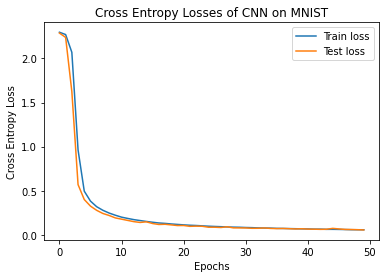

In [12]:
plt.figure()
plt.plot(range(epochs), train_losses, label='Train loss')
plt.plot(range(epochs), test_losses, label='Test loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Cross Entropy Losses of CNN on MNIST')
plt.show()

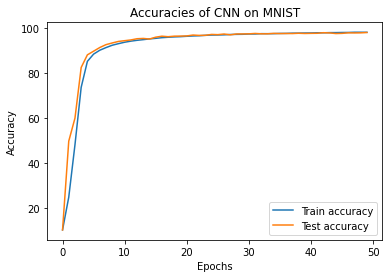

In [13]:
plt.figure()
plt.plot(range(epochs), train_accs*100.0, label='Train accuracy')
plt.plot(range(epochs), test_accs*100.0, label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Accuracies of CNN on MNIST')
plt.show()